&emsp;&emsp;**Метод опорных векторов**

&emsp;&emsp;Метод опорных векторов (support vectors machine, SVM) - довольно мощный алгоритм для задачи классификации, который может рассматриваться как конкурент логистической регрессии. Для пояснения принципа его работы, начнем с функции потерь логистической регрессии с L2 регуляризацией:

$$Loss = -\sum_{i=1}^{n}{[y_{i}ln(p(y_{i})) + (1-y_{i})ln(1-p(y_{i}))]} + \lambda\sum_{j=1}^{m}{w_{j}^{2}}$$

$$p(y_{i}) = \frac{1}{1 + exp(-w^{T}x_{i})}$$

&emsp;&emsp;Так как нас не интересует само значение минимума функции потерь, а скорее значения параметров, при котором она принимает свое минимальное значение, то мы можем разделить эту функцию на константу, что не приведет к изменению точки, в которой находится минимум. Перепишем нашу функцию следующим образом:

$$Loss = С\sum_{i=1}^{n}{[y_{i}(-ln(p(y_{i}))) + (1-y_{i})(-ln(1-p(y_{i})))]} + \sum_{j=1}^{m}{w_{j}^{2}}, \text{ где } C = \frac{1}{\lambda}$$

&emsp;&emsp;Значение $-ln(p(y_{i}))$ - это та потеря, которую мы несем, если пример положительный, а $-ln(1 - p(y_{i}))$ если отрицательный. Построим графики функций этих потерь для некоторого интервала:

In [1]:
import numpy as np
from matplotlib import pyplot as plt

def positive_loss(x):
    return -np.log(1 / (1 + np.exp(-x)))

def negative_loss(x):
    return -np.log(1 - 1 / (1 + np.exp(-x)))

x = np.linspace(-3, 3, 100)

plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
plt.plot(x, positive_loss(x))
plt.title('Positive loss')

plt.subplot(1, 2, 2)
plt.plot(x, negative_loss(x))
plt.title('Negative loss')

plt.show()

&emsp;&emsp;Мы могли бы довольно неплохо приблизить полученные функции потерь следующими более простыми функциями:

In [2]:
def positive_relu(x):
    return np.where(x > 1, 0, 0.75 - 0.75 * x)

def negative_relu(x):
    return np.where(x < -1, 0, 0.75 + 0.75 * x)

plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
plt.plot(x, positive_loss(x))
plt.plot(x, positive_relu(x))
plt.title('Positive loss')

plt.subplot(1, 2, 2)
plt.plot(x, negative_loss(x))
plt.plot(x, negative_relu(x))
plt.title('Negative loss')

plt.show()

&emsp;&emsp;Конкретное значение угла наклона здесь неважно. Что важно понять, так это то, что мы можем перейти от функции с разным значением производной на разных участках к такой, которая дает постоянный штраф на участке меньше 1 для положительных примеров и больше -1 для отрицательных.

&emsp;&emsp; Заменив $-ln(p(y_{i})) = -ln(\frac{1}{1 + exp(-w^{T}x_{i})})$ на $cost_{1}(w^{T}x_{i})$, а $-ln(1-p(y_{i}))$ на $cost_{0}(w^{T}x_{i})$ получим:

$$Loss = С\sum_{i=1}^{n}{[y_{i}cost_{1}(w^{T}x_{i}) + (1-y_{i})cost_{0}(w^{T}x_{i})]} + \sum_{j=1}^{m}{w_{j}^{2}}$$

&emsp;&emsp;Финально, оптимальный набор параметров находим как:

$$w = argmin[С\sum_{i=1}^{n}{[y_{i}cost_{1}(w^{T}x_{i}) + (1-y_{i})cost_{0}(w^{T}x_{i})]} + \sum_{j=1}^{m}{w_{j}^{2}}]$$

&emsp;&emsp;В результате, мы найдем набор параметров w, который будет задавать уравнение гиперплоскости по одну сторону которой находятся примеры первого класса, а по другую второго.

&emsp;&emsp; Построим модель SVM для данных о видах ирисов:

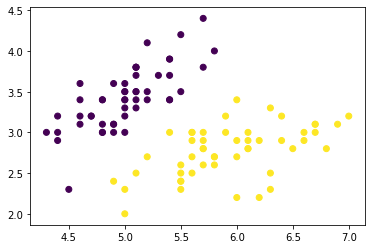

In [3]:
from sklearn import datasets

# выгрузим данные
iris = datasets.load_iris()
X = iris.data[:, :2]  # воспользуемся только первыми двумя колонками
y = iris.target

# удалим один из классов, чтобы остаться с задачей бинарной классификации
X, y = X[y != 2], y[y != 2]

# посмотрим, как выглядят наши данные
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [8]:
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions

# инициализируем модель SVM (в sklearn SVC - support vectors classifier)
svm = SVC(
    C=1.,  # значение константы регуляризации из формулы выше: чем больше, тем слабее регуляризация
    kernel='linear'  # тип расстояния между точками (об этом параметре ниже)
)

svm = svm.fit(X, y)  # обучим модель

# построим график, где отобразим в каких областях какой класс выбирает наша модель
plot_decision_regions(X, y, clf=svm)
plt.show()

ModuleNotFoundError: No module named 'mlxtend'

&emsp;&emsp;Иногда данные невозможно разделить в том пространстве переменных, в котором они изначально находятся, однако это вполне возможно в пространствах более высокой размерности. Повысить размерность данных можно искуственно добавив к переменным значение их квадратов, например. Но какую конкретно функцию стоит выбрать для повышения размерности и сколько новых переменных стоит добавить?

&emsp;&emsp;SVM создает новое пространство высокой размерности, заменяя оригинальные переменные для каждой точки на расстояния до остальных точек в данных. То есть, если в наборе данных n наблюдений, то для каждого можно посчитать n расстояний (включая нулевое расстояние до самого себя) + добавить значение константы, что создаст новое пространство размерности n+1.

&emsp;&emsp;Предложенное выше расстояние вычисляют как $K(x_{i}, x_{j})$, то есть как некоторую функцию от двух точек, которая скорее играет роль расстояния, чем является им на самом деле. Такая функция называется кернелом. Самыми популярными кернелами являются следующие:

$$linear: k(x_{i}, x_{j}) = x_{i}^Tx_{j}$$

$$polynomial: k(x_{i}, x_{j}) = (\gamma x_{i}^{T}x_{j} + r)^{d}$$

$$rbf: k(x_{i}, x_{j}) = exp(-\gamma ||x_{i} - x_{j}||^{2})$$

$$sigmoid: k(x_{i}, x_{j}) = tanh(\gamma x_{i}^{T}x_{j} + r)$$

Попробуем перестроить нашу модель, воспользовавшись RBF кернелом:

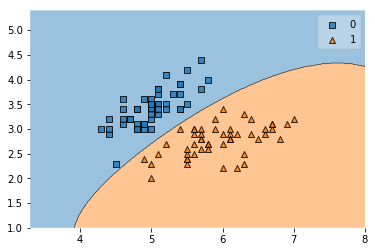

In [89]:
svm = SVC(C=1., kernel='rbf')

svm = svm.fit(X, y)  # обучим модель

# построим график, где отобразим в каких областях какой класс выбирает наша модель
plot_decision_regions(X, y, clf=svm)
plt.show()

&emsp;&emsp;Как и для большинства других моделей переход к нескольким классам целевой переменной осуществляется через построение нескольких моделей - по одной на каждый класс:

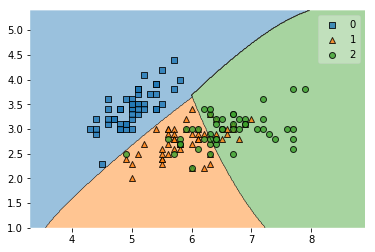

In [90]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

svm = svm = SVC(
    C=1.,
    kernel='rbf',
    decision_function_shape='ovr'  # построить по модели на каждый класс, как "один против всех"
).fit(X, y)

plot_decision_regions(X, y, clf=svm)
plt.show()

&emsp;&emsp;Посмотрим, как влияет параметр регуляризации на форму границы принятия решений:

In [91]:
plot_decision_regions(X, y, clf=SVC(C=100).fit(X, y))  # крайний случай очень слабой регуляризации
plt.show()

&emsp;&emsp;**Подбор гиперпараметров**

&emsp;&emsp;Для SVM, как и для большинства других алгоритмов, встает вопрос о наилучшем наборе гиперпараметров (таких параметров, значения которых нельзя вычислить на основе данных). Какой кернел лучше выбрать, какое оптимальное значение параметра регуляризации? Обычно лучшее значение принято выбирать исходя из результатов работы модели на тестовом наборе, а лучше на кросс-валидации.

&emsp;&emsp;Для того, чтобы упростить это процесс в sklearn есть класс, позволяющий перебрать все комбинации значений разных параметров, оценивая при этом точность модели на кросс-валидации.

In [92]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

svm = SVC()  # инициализация модели

# инициализация значений параметров, для которых произвести поиск (будут протестированы все комбинации значений)
params_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.5, 1, 2, 5]
}

# инициализация объекта для поиска оптимальных значений параметров
clf = GridSearchCV(
    estimator=svm,  # модель, которую необходимо протестировать
    param_grid=params_grid,  # словарь с именами параметров и списком их значений
    scoring='f1_macro',  # название метрики качества, которую необходимо использовать
    cv=4  # количество тестовых наборов
)

clf = clf.fit(X, y)  # поиск значений
grid_search_results = pd.DataFrame(clf.cv_results_)  # получение результатов поиска в виде таблицы
grid_search_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        0.000868      0.000217         0.000992        0.000253     0.5   
1        0.001216      0.000274         0.001169        0.000274     0.5   
2        0.000819      0.000036         0.000832        0.000032     0.5   
3        0.001239      0.000040         0.000915        0.000026     0.5   
4        0.000737      0.000198         0.001117        0.000211       1   
5        0.001324      0.000338         0.001010        0.000200       1   
6        0.000705      0.000038         0.000766        0.000019       1   
7        0.001235      0.000060         0.000891        0.000025       1   
8        0.000525      0.000011         0.000707        0.000010       2   
9        0.001898      0.000483         0.000752        0.000015       2   
10       0.000676      0.000032         0.000762        0.000006       2   
11       0.001228      0.000033         0.000878        0.000028       2   
12       0.000549      0.000014         0.000718        0.000019       5   
13       0.002204      0.000668         0.000740        0.000011       5   
14       0.000688      0.000044         0.000751        0.000004       5   
15       0.001186      0.000008         0.000863        0.000003       5   

   param_kernel                           params  split0_test_score  \
0        linear   {'C': 0.5, 'kernel': 'linear'}           0.753695   
1          poly     {'C': 0.5, 'kernel': 'poly'}           0.753695   
2           rbf      {'C': 0.5, 'kernel': 'rbf'}           0.777778   
3       sigmoid  {'C': 0.5, 'kernel': 'sigmoid'}           0.160000   
4        linear     {'C': 1, 'kernel': 'linear'}           0.777778   
5          poly       {'C': 1, 'kernel': 'poly'}           0.753695   
6           rbf        {'C': 1, 'kernel': 'rbf'}           0.753695   
7       sigmoid    {'C': 1, 'kernel': 'sigmoid'}           0.160000   
8        linear     {'C': 2, 'kernel': 'linear'}           0.777778   
9          poly       {'C': 2, 'kernel': 'poly'}           0.753695   
10          rbf        {'C': 2, 'kernel': 'rbf'}           0.753695   
11      sigmoid    {'C': 2, 'kernel': 'sigmoid'}           0.160000   
12       linear     {'C': 5, 'kernel': 'linear'}           0.777778   
13         poly       {'C': 5, 'kernel': 'poly'}           0.753695   
14          rbf        {'C': 5, 'kernel': 'rbf'}           0.777778   
15      sigmoid    {'C': 5, 'kernel': 'sigmoid'}           0.160000   

    split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
0            0.839744           0.786325           0.858517         0.809570   
1            0.839744           0.760000           0.858517         0.802989   
2            0.865808           0.786325           0.858517         0.822107   
3            0.160000           0.141844           0.111111         0.143239   
4            0.839744           0.760000           0.835288         0.803202   
5            0.839744           0.760000           0.858517         0.802989   
6            0.839744           0.760000           0.858517         0.802989   
7            0.160000           0.141844           0.111111         0.143239   
8            0.839744           0.760000           0.835288         0.803202   
9            0.839744           0.760000           0.858517         0.802989   
10           0.839744           0.760000           0.858517         0.802989   
11           0.160000           0.141844           0.111111         0.143239   
12           0.813333           0.786325           0.835288         0.803181   
13           0.839744           0.760000           0.858517         0.802989   
14           0.813333           0.760000           0.835288         0.796600   
15           0.160000           0.141844           0.111111         0.143239   

    std_test_score  rank_test_score  
0         0.041739                2  
1         0.046670                6  
2         0.040252          

&emsp;&emsp;**Наивный Байесовский классификатор**

&emsp;&emsp;Начнем с некоторых определений: 

&emsp;&emsp;Условная вероятность: $P(y|x)$ - вероятность того, что произойдет событие y, если уже произошло событие x. 

&emsp;&emsp;Совместная вероятность: $P(y, x)$ - вероятность того, что события x и y произойдут одновременно. 

&emsp;&emsp;Безусловная вероятность: $P(x)$ - вероятность того, что произойдет событие х. 

&emsp;&emsp;Вероятность того, что оба события произойдут, равна вероятности того, что произойдет первое, а потом второе, при условии, что первое только что произошло. Порядок при этом неважен. Формально можем записать:

$$P(x, y) = P(y|x)P(x) = P(x|y)P(y)$$

&emsp;&emsp;При этом, если события независимые друг от друга, то $P(y|x)=P(y)$ и для них $P(x, y) = P(x)P(y)$

&emsp;&emsp;Если переписать первое соотношение, то получим известную формулу Байеса:

$$P(y|x) = \frac{P(y)P(x|y)}{P(x)}$$

&emsp;&emsp;Если переменных х несколько, то в более общем виде можем записать:

$$P(y|x_{1}, \dots, x_{n}) = \frac{P(y)P(x_{1}, \dots, x_{n}|y)}{P(x_{1}, \dots, x_{n})}$$

&emsp;&emsp;Сделаем следующее предположение (из-за которого классификатор получил название "наивный", так как в большинстве случаев оно некорректно): все переменные х независимы друг от друга. Формально это означает следующее:

$$P(x_{i}|y, x_{1}, \dots, x_{i-1}, x_{i+1}, \dots, x_{n}) = P(x_{i}|y)$$

&emsp;&emsp;Тогда предыдущую формулу можно переписать в следующем виде:

$$P(y|x_{1}, \dots, x_{n}) = \frac{P(y)\prod_{i=1}^{n}{P(x_{i}|y)}}{P(x_{1}, \dots, x_{n})}$$

&emsp;&emsp;Знаменатель $P(x_{1}, \dots, x_{n})$ является константой, зависящей только от конкретного набора данных. Вероятность того, что y принадлежит тому или иному классу, пропорциональна числителю формулы, и мы можем принять решение о том, куда отнести новый пример, выбрав тот класс, для которого значение числителя больше. Формально можем записать: 

$$y_{class} = argmaxP(y)\prod_{i=1}^{n}{P(x_{i}|y)}$$

&emsp;&emsp;Последнее, что нам остается сделать, чтобы пользоваться предложенным алгоритмом на практике, это оределиться, чему равно $P(x_{i}|y)$ (вероятность конкретного значения $x_{i}$ при условии, что наблюдение принадлежит классу y). Эта вероятность определяется исходя из специфики задачи. Если взять для примера задачу классификации ирисов, то переменные можно считать приблизительно нормально распределенными и эта вероятность будет пропорциональна плотности функции нормального распределения:

$$P(x_{i}|y) = \frac{1}{\sqrt{2\pi}\sigma_{y}}exp(-\frac{(x_{i} - \mu_{y})^{2}}{2\sigma_{y}^{2}})\text{ , где}$$

$$\sigma_{y}\text{ - дисперсия переменной х, посчитанная только для примеров класса у}$$

$$\mu_{y}\text{ - среднее значение переменной х, посчитанное только для примеров класса у}$$

&emsp;&emsp;Теперь все готово, для построения самой модели.

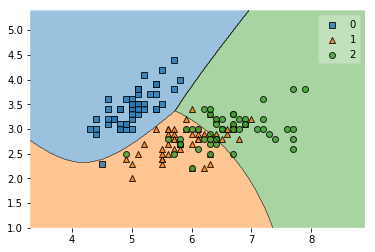

In [93]:
# GaussianNB - вид классификатора, для которого вероятность P(x|y) определена пропорционально плотности
# нормального распределения, как было предложено выше
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X, y)  # определение и оценка классификатора

# построим график с областями принятия решений
plot_decision_regions(X, y, clf=gnb)
plt.show()

&emsp;&emsp;**Метод к-средних**

&emsp;&emsp;Метод к-средних - это один из самых простых и популярных алгоритмов кластеризации. Кластеризация сама по себе - это процесс группировки данных в некоторые группы (кластеры) по принципу близости друг у другу. Если точки расположены в пространстве близко друг к другу, то есть смысл предположить, что они могут принадлежать к одному классу. При этом, явная информация о классе не используется, поэтому все алгоритмы кластеризации называются обучением буз учителя (учитель не дает правильные ответы, не показывая истинные классы при обучении).

&emsp;&emsp;Используется кластеризация чаще всего для понижения размерности пространства. К примеру, если некоторое явления описывается сотнями переменных, но есть возможность сгруппировать все наблюдения в четкие кластеры, то вместо сотен переменных можно воспользоваться всего одной факторной, которая соответствует номеру кластера, в который попадает точка. С другой стороны, можно принять решение построить несколько отдельных моделей для каждого кластера, если есть причины ожидать разного поведения или же просто добавить кластеры как дополнительную переменную, что тоже часто позволяет улучшить результаты оригинальной модели.

&emsp;&emsp;Реже кластерами пользуются для прогнозирования: для нового наблюдения выдать среднее значение того кластера, к которому оно относится.

&emsp;&emsp;Начинается алгоритм к-средних с того, что мы выберем число кластеров, на которое хотим разделить наши данные, и попробуем угадать, где находятся центры этих кластеров. При этом будем относить каждую точку к тому кластеру, к центру которого она находится ближе всего: 

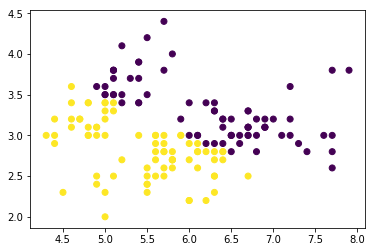

In [94]:
np.random.seed(1)  # зафиксируем слуайное состояние

num_clusters = 2  # выберем количество кластеров

# сделаем догадку, где находятся оптимальные центры этих кластеров, выбрав 2 случайные точки из данных
guess = X[np.random.choice(range(len(X)), size=num_clusters, replace=False),:]

# посчитаем расстояние от каждой точки до наших центров
distances = np.empty((X.shape[0], num_clusters))
for i in range(num_clusters):
    diff = X - guess[i]
    distances[:, i] = np.linalg.norm(diff, axis=1)
    
cluster = np.argmin(distances, axis=1) # выберем к какому кластеру лучше отнести каждую точку

# построим наш результат на графике
plt.scatter(X[:, 0], X[:, 1], c=cluster)
plt.show()

&emsp;&emsp;Теперь, уже имея кластеры, можем посчитать среднее значение в каждом из них и определить настоящий центр полученных кластеров. При этом, некоторые точки, возможно, поменяют свой кластер:

In [95]:
# вычислим положение центров кластеров
cluster_means = np.array([np.mean(X[cluster==i], axis=0) for i in range(num_clusters)])

# пересчитаем результаты имея новые оценки центров
distances = np.empty((X.shape[0], num_clusters))
for i in range(num_clusters):
    diff = X - cluster_means[i]
    distances[:, i] = np.linalg.norm(diff, axis=1)

cluster = np.argmin(distances, axis=1)

plt.scatter(X[:, 0], X[:, 1], c=cluster)
plt.show()

&emsp;&emsp;Есть смысл повторять процедуру до тех пор, пока положения центров кластеров не перестанут существенно меняться:

In [96]:
# зададим начальные параметры алгоритма
np.random.seed(1)  # зафиксируем слуайное состояние
means0 = X[np.random.choice(range(len(X)), size=num_clusters, replace=False),:]  # догадка о положении центров
distances = None
cluster = np.zeros(len(X))
epsilon = 0.01  # максимальное изменение, после которого считаем, что центры уже не меняются

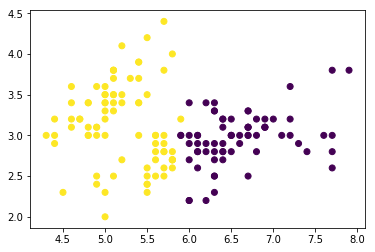

In [97]:
while True:
    # распределим точки по кластерам
    distances = np.empty((X.shape[0], num_clusters))
    for i in range(num_clusters):
        diff = X - means0[i]
        distances[:, i] = np.linalg.norm(diff, axis=1)

    cluster = np.argmin(distances, axis=1)
    
    # получим текущие средние значения и сравним, как они изменились по сравнению в предыдущими
    means1 = np.array([np.mean(X[cluster==i], axis=0) for i in range(num_clusters)])
    if np.sum(np.abs(means0 - means1)) <= epsilon:
        break  # прерываем поиск, если средние практически не изменились
    else:
        means0 = means1

# сохраним результаты для дальнейшего сравнения
attempt1_distances, attempt1_clusters = distances, cluster

plt.scatter(X[:, 0], X[:, 1], c=cluster)
plt.show()

&emsp;&emsp;Повторив эту процедуру начиная с другой догадки можно оказаться с другими кластерами:

In [98]:
# зададим начальные параметры алгоритма
np.random.seed(28)  # зафиксируем слуайное состояние
means0 = X[np.random.choice(range(len(X)), size=num_clusters, replace=False),:]  # догадка о положении центров
distances = None
cluster = np.zeros(len(X))
epsilon = 0.01  # максимальное изменение, после которого считаем, что центры уже не меняются

In [99]:
while True:
    # распределим точки по кластерам
    distances = np.empty((X.shape[0], num_clusters))
    for i in range(num_clusters):
        diff = X - means0[i]
        distances[:, i] = np.linalg.norm(diff, axis=1)

    cluster = np.argmin(distances, axis=1)

    # получим текущие средние значения и сравним, как они изменились по сравнению в предыдущими
    means1 = np.array([np.mean(X[cluster==i], axis=0) for i in range(num_clusters)])
    if np.sum(np.abs(means0 - means1)) <= epsilon:
        break  # прерываем поиск, если средние практически не изменились
    else:
        means0 = means1

# сохраним результаты для дальнейшего сравнения
attempt2_distances = distances
attempt2_clusters = cluster

plt.scatter(X[:, 0], X[:, 1], c=cluster)
plt.show()

&emsp;&emsp;Как понять какой вариант лучше? Обычно предпочтительным считается тот, который создал более однородные кластеры. Мерой однородности можно считать сумму квадратов расстояний от каждой точки, до ближайшего центра кластера: чем она меньше, тем более однородный кластер:

In [100]:
attempt1_ss = np.sum(np.min(attempt1_distances ** 2, axis=1))
attempt2_ss = np.sum(np.min(attempt2_distances ** 2, axis=1))

print(attempt1_ss, attempt2_ss)

58.21499731615674 58.44759246088194


&emsp;&emsp;В данном случае мы должны предпочесть первый вариант, хотя результаты практически не отличаются. На практике, алгоритм сделает несколько попыток инициализации кластеров и оставит ту, при которой сумма квадратов расстояний минимальна.

In [101]:
from sklearn.cluster import KMeans

# инициализируем модель кластеризации
km = KMeans(
    n_clusters=2,  # количество кластеров
    n_init=10,  # количество попыток инициализации
    random_state=42  # фиксация случайного состояния
)

# получим значения кластеров
km = km.fit(X)
clusters = km.labels_

plt.scatter(X[:, 0], X[:, 1], c=clusters)
plt.show()

&emsp;&emsp;Основной параметр, который нам нужно выбрать - это количество кластеров. Пользоваться в нашем случае критерием однородности прямо, нельзя, так как в худшем случае можно создать столько кластеров, сколько есть точек в наборе данных, что даст нулевую дисперсию (идеально однородные кластеры). Очевидно, от таких кластеров будет мало толку, поскольку они не имеют никаких обобщающих свойств.

&emsp;&emsp;Имплементация KMeans в sklearn позволяет получить критерий однородности как атрибут itertia: сумму квадратов расстояний до ближайших центров. Построим график зависимости этого значения для разного количества кластеров:

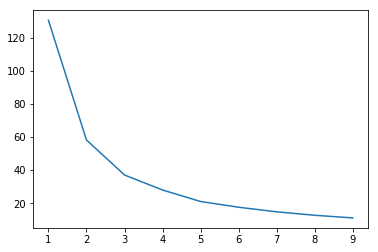

In [102]:
inertias = []
for num_clusters in range(1, 10):
    
    km = KMeans(n_clusters=num_clusters).fit(X)
    inertias.append(km.inertia_)
    
plt.plot(range(1, 10), inertias)
plt.show()

&emsp;&emsp;Такой график называется "локтевым" (elbow plot) из-за схожести с формой локтя. Выбрать количество кластеров следует таким, где у этого графика примерно находится самый сильный изгиб. В нашем случае это где-то 2-3, что приблизительно соответствует количеству наших классов в данных. 

&emsp;&emsp;Финальное решение нужно принимать по результатам кросс-валидации той модели, для которой эта кластеризация создавалась.

&emsp;&emsp;**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**

&emsp;&emsp;У алгоритма к-средних есть ряд недостатков, которые делают невозможным его использование в некоторых ситациях. А именно:

&emsp;&emsp;1. Далеко невсегда есть возможность точно определить количество кластеров. К примеру, если входящими данными являются координаты и мы хотим получить кластеры, в которых чаще всего бывает тот или иной пользователь, то очевидно, количество кластеров будет индивидуальным.

&emsp;&emsp;2. Кластеры, которые получаются при использовании к-средних обычно имеют сферическую форму, так как алгоритм стремится создать для каждого среднего некоторое окружение из точек. Если есть основания ожидать другую форму кластеров (к примеру, если кластерами являются траектории движения), то к-средних может быть далеко не лучшим выбором.

&emsp;&emsp;3. Эвклидово расстояние на плоскости, которым по-умолчанию пользуется алгоритм, не всегда корректно. В том же примере с координатами пользователей, мы можем хотеть воспользоваться другой мерой расстояния, определенной на сфере.

&emsp;&emsp;4. К-средних всегда подберет лучший кластер для каждой точки в данных. Однако иногда это нежелательно из-за присутствия выбросов, которые было бы лучше просто проигнорировать и не относить ни к какому кластеру вообще.

&emsp;&emsp;Алгоритм кластеризации DBSCAN способен решить все перечисленные выше проблемы. Идея алгоритма следующая: 

&emsp;&emsp;1. Начать с какой-то случайной точки в данных и отнести к ее кластеру все соседние точки на расстоянии не больше заданного. 

&emsp;&emsp;2. Дальше переходим к следующей точке в этом же кластере и пытемся тем же образом найти соседей для нее. 

&emsp;&emsp;3. Когда рядом больше нет точек, которые находились бы в зоне досягаемости, то переходим к тем точкам, которые еще не имеют своего кластера. 

&emsp;&emsp;4. Финально отбрасываем те кластеры, которые содержат меньше n точек, считая их случайным шумом. 

&emsp;&emsp;Для иллюстрации работы алгоритма и сравнения с к-средних воспользуемся данными, которые напоминают по форме 2 полумесяца. Такие данные могут быть примером двух траекторий движения в пространстве:

In [103]:
# сгенерируем интересеющие нас данные и посмотрим, как выглядят полученные кластеры
X, y = datasets.make_moons(n_samples=500, noise=.1, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

&emsp;&emsp;Определим оптимальное количество кластеров для к-средних

In [104]:
inertias = []
for num_clusters in range(1, 10):
    
    km = KMeans(n_clusters=num_clusters).fit(X)
    inertias.append(km.inertia_)
    
plt.plot(range(1, 10), inertias)
plt.show()

&emsp;&emsp;То есть, стоит взять 2 кластера

&emsp;&emsp;Разделим данные на 2 кластера с помощью к-средних и посмотрим, что получилось:

In [105]:
km_clusters = KMeans(n_clusters=2).fit(X).labels_

plt.scatter(X[:, 0], X[:, 1], c=km_clusters)
plt.show()

&emsp;&emsp;Теперь воспользуемся DBSCAN и посмотрим, можем ли мы сделать лучше

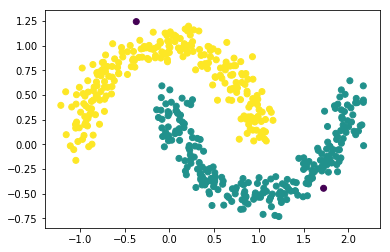

In [106]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(
    eps=0.15,  # максимальное расстояние между точками, чтобы их все еще можно было отнести к одному кластеру
    min_samples=5,  # минимальное кол-во точек, при которых кластер стоит оставить
    metric='euclidean'  # мера расстояния; 'euclidean' - соответствует стандартному расстоянию на плоскости
)

dbs = dbs.fit(X)  # обучим модель кластеризации
dbs_clusters = dbs.labels_  # получим значения кластеров для каждой точки

plt.scatter(X[:, 0], X[:, 1], c=dbs_clusters)
plt.show()

&emsp;&emsp;Как видим, нам удалось получить 2 идеальных кластера, при этом 2 точки были проигнорированы (они находятся в отдельном кластере с индексом -1)

&emsp;&emsp;**Иерархическая кластеризация**

&emsp;&emsp;Идея иерархической кластеризации заключается в следующем:

&emsp;&emsp;1. Инициализируем кластеры в каждой точке данных: таким образом мы получим n кластеров (где n - количество наблюдений в данных). Полученные кластеры будут идеально однородными в том смысле, что диспесия внутри каждого кластера равна 0.

&emsp;&emsp;2. Дальше берем один кластер и объединяем его с ближайшим соседом. При этом дисперсия внутри кластера возрастет (мы перейдем от кластеров, содержавших только 1 точку к кластеру 2х точек). Если дисперсия возросла на небольшую величину (меньше наперед заданного порога), то считаем такое объединения позволительным и идем дальше, в противном случае отменяем слияние кластеров.

&emsp;&emsp;3. Берем еще один кластер (возможно, тот же самый, который мы получили на предыдущем шаге) и повторяем процедуру объединения с соседом. Продолжаем объединять соседние кластеры друг с другом до тех пор, пока дальнейшее объединение соседей не приводит к росту дисперсии больше дозволительного порога или достигнуто желаемое количество кластеров.

&emsp;&emsp;Для иллюстрации идеи выберем несколько точек из наших данных про ирисы и создадим кластеры по предложенному выше алгоритму:

In [107]:
X0_sample, y0_sample = X[y == 0][:3], y[y == 0][:3]  # топ 3 наблюдения класса 0
X1_sample, y1_sample = X[y == 1][:3], y[y == 1][:3]  # топ 3 наблюдения класса 1

# объединим выборки из разные классов в одну таблицу
Xsample, y_sample = np.concatenate([X0_sample, X1_sample]), np.concatenate([y0_sample, y1_sample])

# построим график и добавим индекс точки в данных
plt.scatter(Xsample[:, 0], Xsample[:, 1], c=y_sample)
for i in range(len(y_sample)):
    plt.annotate(i, (Xsample[i, 0], Xsample[i, 1]))  # добавим аннотацию в виде индекса к каждой точке
    
plt.show()

In [108]:
import scipy.cluster.hierarchy as shc

dend = shc.dendrogram(shc.linkage(Xsample, method='ward'))  # построим дендрограмму
# добавим горизонтальную линию, которая будет иллюстрацией порога ухудшения однородности кластеров
plt.axhline(y=1.5, color='r', linestyle='--')
plt.show()

&emsp;&emsp;Разберем полученный график. На горизонтальной оси находятся индексы точек в оригинальных данных; на вертикальной - расстояние между точками.

&emsp;&emsp;Начинали мы с 6 кластеров, что соответствует 6 точкам в данных. В первую очередь нам стоит объединить в один кластер точки 4 и 5, так как они находятся на расстоянии друг от друга, примерно, 0.2. Далее полученный кластер из точек {4, 5} можем объединить с точкой 3, так как расстояние от центра этого кластера до этой точки - 0.4. Делаем то же самое с точкими 0 и 2, а затем добавляем точку 1.

&emsp;&emsp;Финально, получив кластеры {3, 4, 5} и {1, 0, 2} мы можем и их объединить, если допустим большие расстояния при слиянии. Однако, ограничив максимальное расстояние между кластерами для объединения, скажем, на уровне 1.5, то мы останемся с этими 2-мя кластерами, что идеально соответствует разделению между классами.

In [109]:
# полный пример кластеризации с использованием класса sklearn
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(
    n_clusters=None,  # параметр позволяет указать желаемое кол-во кластеров
    affinity='euclidean',  # тип расстояния между точками
    linkage='ward',  # мера ухудшения при объединении: ward - прирост дисперсии расстояний
    distance_threshold=10.  # максимальное ухудшение метрики при объединении, при котором объединение возможно
).fit(X)

# получим индексы кластеров и построим график
ac_clusters = ac.labels_

plt.scatter(X[:,0], X[:,1], c=ac_clusters)
plt.show()


&emsp;&emsp;**Анализ главных компонент (PCA - principal components analysis)**

&emsp;&emsp;Начнем с определений:

&emsp;&emsp;Собственный вектор квадратной матрицы это такой ненулевой вектор, который при умножении на данную матрицу превращается в себя, умноженного на некоторый коэффициент. Сам же коэффициент, на который домножается оригинальный вектор в результате, называется собственным числом матрицы:

$$Av = \lambda v$$
&emsp;&emsp;Где $v$ - собственный вектор, а $\lambda$ - собственное число матрицы $А$. СТоит отметить, что любой другой вектор $v^{*}$, который совпадает с вектором $v$, но является в n раз длиннее, тоже считается собственным вектором. Таким образом получается, что матрица имеет бесконечно много собственных векторов, однако большинство из них линейно зависимые.

&emsp;&emsp;Находятся собственные числа и собственные векторы следующим образом (на примере квадратной матрицы 2х2):

$$A = \begin{pmatrix} a & b \\ c & d \end{pmatrix}$$

$$v = \begin{pmatrix} x\\y \end{pmatrix}$$

$$Av = \lambda v => \begin{pmatrix} a & b \\ c & d \end{pmatrix}\begin{pmatrix} x\\y \end{pmatrix} = \lambda \begin{pmatrix} x\\y \end{pmatrix} =>$$

$$=> \begin{pmatrix} ax + by \\ cx + dy \end{pmatrix} = \begin{pmatrix} \lambda x\\\lambda y \end{pmatrix} => \begin{pmatrix} ax + by - \lambda x \\ cx + dy - \lambda y \end{pmatrix} = \begin{pmatrix} 0 \\ 0 \end{pmatrix} => \begin{pmatrix} x(a - \lambda) + by \\ cx + y(d - \lambda) \end{pmatrix} = \begin{pmatrix} 0 \\ 0 \end{pmatrix} =>$$

$$ => x\begin{pmatrix} (a - \lambda)\\c \end{pmatrix} + y\begin{pmatrix} b\\(d - \lambda) \end{pmatrix} = \begin{pmatrix} 0 \\ 0 \end{pmatrix}$$

&emsp;&emsp;Последняя строка означает, что векторы $\begin{pmatrix} (a - \lambda)\\c \end{pmatrix}$ и $\begin{pmatrix} b\\(d - \lambda) \end{pmatrix}$ линейно зависимые. Это в, свою очередь, означает, что у матрицы $B = \begin{pmatrix} (a - \lambda) & b \\ c & (d - \lambda) \end{pmatrix}$ определитель равен 0. Таким образом нам осталось найти такие значения $\lambda$, для которых $det(B) = 0.$

&emsp;&emsp;Для матрицы 2х2 вида $\begin{pmatrix} a & b \\ c & d \end{pmatrix}$ определитель равен $ad - bc$. То есть нам осталось решить уравнение $(a - \lambda)(d - \lambda) - bc = 0$ из которого получим два корня $\lambda_1, \lambda_2$, соответствующие 2м линейно независимым собственным векторам. Взяв одно из собственных чисел, можем вернуться к уравнению $x\begin{pmatrix} (a - \lambda)\\c \end{pmatrix} + y\begin{pmatrix} b\\(d - \lambda) \end{pmatrix} = \begin{pmatrix} 0 \\ 0 \end{pmatrix}$ и подставляя в него произвольные x, y, которые удовлетворяют равенству, определить собственные векторы, соответствующие этому собственному числу.

&emsp;&emsp;В общем случае, матрица A размера nxn полного ранга будет иметь n собственных чисел и n линейно независимых векторов (не считая того, что каждый собственный вектор имеет бесконечно много "двойников" отличающихся от него только длиной). Собственные числа в общем случае находятся следующим образом:

$$Av = \lambda v => Av - \lambda Iv = 0 => (A - \lambda I)v = 0 => det(A - \lambda I) = 0$$

&emsp;&emsp;Так как одному собственному числу соответствует много собственных векторов, в программной имплементации принято выдавать такой из них, длина которого навна 1. Рассмотрим пример:

In [110]:
np.random.seed(42)
A = np.random.randint(0, 10, (2, 2))  # создадим квадратную матрицу из случайных чисел
eigen_values, eigen_vectors = np.linalg.eig(A)  # найдем собственные числа и векторы матрицы

print(eigen_values)
print(eigen_vectors)

[9.69041576 0.30958424]
[[ 0.63078729 -0.46636038]
 [ 0.77595579  0.88459482]]


In [111]:
# убедимся, что первый вектор действительно является собственным

# умножим первый собственный вектор на матрицу А слева
actual_transform = A.dot(eigen_vectors[:, 0])
# умножим первый собственный вектор на первое собственное число
theor_transform = eigen_values[0] * eigen_vectors[:, 0]

print(actual_transform, theor_transform)

[6.11259114 7.51933422] [6.11259114 7.51933422]


&emsp;&emsp;Если записать все собственные вектора как столбцы матрицы $Q$, как это сделано в реализации numpy, то можно прийти к следующей формуле $AQ = Q\Lambda$ (где $\Lambda$ - диагональная матрица, состоящая из собственных чисел), откуда следует 

$$AQQ^{-1} = Q\Lambda Q^{-1} => A = Q\Lambda Q^{-1}$$

&emsp;&emsp;Последняя формула называется спектральное разложение матрицы, где собственные значения $\Lambda$ называются спекторм матрицы. У этого разложения есть ряд очень полезных свойств. Одно из них следующее: чтобы возвести матрицу A в степень n, можно возвести в степень n каждое собственное число этой матрицы, а затем получить $A^{n} = Q\Lambda^{n} Q^{-1}$. На практике так и делают, что работает гораздо быстрее, чем последовательное умножение матрицы на саму себя.

&emsp;&emsp;Другое свойство, которым мы будем пользоваться следующее: если А симметричная матрица, то все ее собственные вектора, соответствующие разным собственным числам, ортогональны друг другу.

&emsp;&emsp;Теперь можем переходить непосредственно к PCA. Предположим, у нас имеются 2 коррелирующие друг с другом переменные:

In [112]:
x1 = np.random.normal(1, 2, size=(100, 1))  # создадим первую переменную
x2 = x1 + np.random.normal(1, 0.5, size=(100, 1))  # получим вторую переменную прибавив к первой случайный шум

X = np.concatenate([x1, x2], axis=1)  # объединим обе переменные в одну матрицу

# отобразим наши переменные на графике
plt.scatter(x1, x2)
plt.show()

&emsp;&emsp;Форма нашего графика зависит от осей, в которых мы его построили. На данный момент это сами переменные х1 и х2. Однако, мы могли бы подобрать другие координатные оси ах1 и ах2, в которых наши данные бы выглядели иначе. Сделаем это таким образом, чтобы 

&emsp;&emsp;1. В новых осях корреляции между переменными не было 

&emsp;&emsp;2. Точка (0, 0) в новых координатах совпадала с "центром" наших данных

&emsp;&emsp;3. Большая часть вариации наших данных находилась вдоль одной из осей

In [113]:
var_means = np.mean(X, axis=0)  # вычислим средние значения переменных
X_centered = X - var_means  # отнимем средние значения от оригинальных переменных
X_covar = X_centered.T.dot(X_centered)  # найдем ковариационную матрицу X
eigen_values, eigen_vectors = np.linalg.eig(X_covar)  # найдем собственные числа и собственные векторы

# выберем в качестве первой оси собственный вектор, который соответствует макимальному собственному числу,
# а второй тот, который соответствует второму по величине (в нашем случае минимальному)
ax1, ax2 = eigen_vectors[:, np.argmax(eigen_values)], eigen_vectors[:, np.argmin(eigen_values)]

# найдем значение переменных в новых осях, домножив матрицу оригинальных переменных на матрицу собственных векторов
X_transform = X_centered.dot(np.vstack([ax1, ax2]))

In [114]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(x1, x2)
plt.arrow(*var_means, *ax1 * 5, head_width=0.05, head_length=0.1)
plt.arrow(*var_means, *ax2 * 5, head_width=0.05, head_length=0.1)
plt.xlim(-6, 6)
plt.subplot(122)
plt.scatter(x1, x2, label='Переменные в оригинальных осях')
plt.scatter(X_transform[:, 0], X_transform[:, 1], label='Переменные в новых осях')
plt.axvline(0)
plt.axhline(0)
plt.legend()
plt.show()

&emsp;&emsp;На самом деле, нам не столько важны новые оси, сколько преобразование оригинальных переменных, которое необходимо провести, чтобы отобразить их в новых осях. Для того, чтобы получить новые переменные в новых осях, которые отвечают изложенным выше требованиям, мы должны сделать следующее:

&emsp;&emsp;1. Сместим "центр" наших данных в начало координат. Это делается путем вычитания среднего значения переменных (тогда, очевидно, новое среднее будет равно 0 и совпадет с началом координат)

&emsp;&emsp;2. Для того, чтобы получить новые переменные в новых осях, определим некоторые векторы $w_{1}$ и $w_{2}$ тикие, что точка в новых осях получается на основе точки в старых как $x_{new} = (x_{old}, y_{old})w_{1}$, $y_{new} = (x_{old}, y_{old})w_{2}$


&emsp;&emsp;3. Мы так же хотим, чтобы дисперсия первой переменной в новых осях была максимальной, то есть

$$Var(x_{new}) = \frac{1}{n}\sum_{i=1}^{n}{(x_{new}^{i} - \mu_{x_{new}})^{2}} = \frac{1}{n}\sum_{i=1}^{n}{((x_{old}, y_{old})^{i}w_{1} - \mu_{x_{new}})^{2}} ->max$$

&emsp;&emsp;Учитывая, что в новых осях среднее значение $x_{new} = 0$ мы можем его не писать. Так же, мы можем проигнорировать множитель $\frac{1}{n}$, так как он не влияет на положение точки, в которой достигается максимум дисперсии. Отсюда можем вычислить значение $w_{1}$:

$$w_{1} = argmax\sum_{i=1}^{n}{((x_{old}, y_{old})^{i}w_{1})^{2}}$$

&emsp;&emsp;Объединив все $(x_{old}, y_{old})$ в матрицу Х можем записать в матричной форме:

$$w_{1} = argmax[(Xw_{1})^{T}Xw_{1}] = argmax[w_{1}^{T}X^{T}Xw_{1}]$$

&emsp;&emsp;Дело в том, что увеличивая длину вектора $w_{1}$ мы можем получить сколь угодно большое значение дисперсии, однако в этом будет мало практической ценности (взять более длинный $w_{1}$ равносильно тому, чтобы домножить каждую точку $x_{new}$ на некоторую константу). Поэтому мы ограничим себя добавив, что вектор $w_{1}$ должен иметь единичную длину. На приктике это ограничение вводят следующим образом:

$$w_{1} = argmax\frac{w_{1}^{T}X^{T}Xw_{1}}{w_{1}^{T}w_{1}}$$

&emsp;&emsp;Можно показать, что интересующий нас вектор $w_{1}$ равен собственному вектору матрицы $X^{T}X$, соответствующему максимальному собственному числу. В свою очередь, матрица $X^{T}X$ равна ковариационной матрице $X$ после того, как мы отняли от $X$ средние значения переменных. Финально оказывается, что все векторы $w$ (в нашем случае их только 2: $w_{1}$ и $w_{2}$) соответствуют собственным векторам матрицы $X^{T}X$.

&emsp;&emsp;Переменные, полученные нами в новых осях называются главными компонентами (principal components). На практике часто встречаются данные, в которых очень много переменных и многие из них сильно связаны между собой. Перейдя к новой системе координат мы можем отказаться от тех переменных, дисперсия которых меньше всего (считается, что чем выше дисперсия переменной, тем больше в ней содержится информации; в худшем случае, переменная может быть константой, что соответствует 0-ой дисперсии и тогда она нам совершенно неинтересна в процессе анализа).

&emsp;&emsp;В примере выше мы могли бы проигнорировать полученную переменную ax2, так как большая часть информации сосредоточена вдоль горизонтальной оси. Процент объясненной дисперсии теми компонентами, которые мы решили оставить, вычисляют как отношение суммы собственных чисел тех компонент, которые мы оставили к общей сумме собственных чисел:

In [31]:
print(f'Переменная ax1 содержит {np.round(100 * eigen_values[1] / np.sum(eigen_values), 1)} % дисперсии')

Переменная ax1 содержит 98.5 % дисперсии


&emsp;&emsp;Это соответствует действительности, так как вторая созданная нами оригинальная переменная абсолютно неинформативна и перейдя только к одной главной компоненте мы сохраним практически всю интересующую нас информацию.

&emsp;&emsp;Рассмотрим пример с ирисами:

In [43]:
from sklearn.decomposition import PCA

# выгрузим данные
iris = datasets.load_iris()
X = iris.data  # на этот раз возьмем все 4 переменные, описывающие цветок
y = iris.target

# найдем главные компоненты
pca = PCA(
    n_components=4  # найдем все 4 возможные компоненты, так как у нас есть 4 оригинальные переменные
).fit(X)

# построим график объясненной дисперсии каждой компонентой
plt.bar(range(4), pca.explained_variance_ratio_)
plt.show()

&emsp;&emsp;То есть, мы могли бы оставить только первую компоненту, понизив таким образом размерность данных с 4 до 1, сохриняя при этом почти 90% дисперсии. Отобразим наши данные на графике из первых 2х главных компонент: 

In [44]:
X_transform = pca.transform(X)  # перейдем к новым осям

plt.scatter(X_transform[:, 0], X_transform[:, 1], c=y)
plt.show()